In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [181]:
#################################################
############ DEFINIZIONE DI FUNZIONI ############
#################################################

In [182]:
def numerov(k2, h, ya, yb, direction='forward'):
    """
    Algoritmo di numerov
    """ 
    M=len(k2)
    y=np.zeros(M)
    
    # FORWARD NUMEROV ALGORYTM
    if direction=='forward':
        #initial conditions
        y[0]=ya
        y[1]=yb
        #algorytm
        for i in range(1,M-1):
                y[i+1] = (y[i] * (2- 5*h**2/6 * k2[i]) - y[i-1] * (1 + h**2/12 * k2[i-1]) ) / (1 + h**2/12 * k2[i+1])

                
    # BACKWORD NUMEROV ALGORYTM
    if direction=='backward':
        y=np.zeros(M)
        #initial conditions
        y[M-1]=ya
        y[M-2]=yb
        #algorytm
        for i in range(M-2,0,-1):
                y[i-1] = (y[i] * (2- 5*h**2/6 * k2[i]) - y[i+1] * (1 + h**2/12 * k2[i+1]) ) / (1 + h**2/12 * k2[i-1])

    return y

In [58]:
def root_finder(f, begin, end_or_n_roots, step, tol, method='n_roots' ):
    """
    Find roots of a function

    'n_roots' or 'end'
    """

    if method == 'end':
        # coarse find of roots
        E=np.arange(begin,end_or_n_roots,step)
        yM=f(E)
        
        root_bound=[]
        for i in range(1,len(E)):
            if np.sign(yM[i]) != np.sign(yM[i-1]):
                root_bound.append([i-1,i])

    
        # finer find of roots
        roots=[]
        for k in root_bound:
            E_p=E[k[1]]
            E_m=E[k[0]]
            n_iter=0
            #while (abs((E_p-E_m)/(E_p+E_m)*2)>tol)&(n_iter<100):
            while (abs((E_p-E_m)/2)>tol)&(n_iter<100):
                E_temp=(E_p+E_m)/2
                if np.sign(f(E_m)) != np.sign(f(E_temp)):
                    E_p = E_temp
                if np.sign(f(E_temp)) != np.sign(f(E_p)):
                    E_m = E_temp
                n_iter=n_iter+1
            roots.append([(E_p+E_m)/2, E_p-E_m])

    if method =='n_roots':
        # coarse find of roots

        E1=begin
        E2=begin+step
        y1=f(E1)

        root_bound=[]
        while len(root_bound)<end_or_n_roots:
            y2=f(E2)
            if np.sign(y2) != np.sign(y1):
                root_bound.append([E1,E2])
            y1=y2
            E1=E1+step
            E2=E2+step

    
        # finer find of roots
        roots=[]
        for k in root_bound:
            E_p=k[0]
            E_m=k[1]
            n_iter=0
            while (abs(E_p-E_m)>tol)&(n_iter<100):
                E_temp=(E_p+E_m)/2
                if np.sign(f(E_m)) != np.sign(f(E_temp)):
                    E_p = E_temp
                if np.sign(f(E_temp)) != np.sign(f(E_p)):
                    E_m = E_temp
                n_iter=n_iter+1
            roots.append([(E_p+E_m)/2, E_p-E_m])

    return roots

In [213]:
def eigenvalue_finder(f, begin, stop, step, tol, stop_method='n_roots' ):
    """
    Find the eigenvalues of the Numerov problem looking for the zeros of the last point y_M
    'n_roots' or 'range'
    """
    
    # coarse find of roots

    E1=begin
    E2=begin+step
    y1=f(E1)
    M=len(y1)-1
    y1_M=y1[M]
    del y1
    

    root_bound=[]
    while len(root_bound)<stop if stop_method=='n_roots' else E2 <= stop:
        y2_M=f(E2)[M]
        if np.sign(y2_M) != np.sign(y1_M):
            root_bound.append([E1,E2])
        y1_M=y2_M
        E1=E1+step
        E2=E2+step
    
    # finer find of roots
    roots=[]
    for k in root_bound:
        #initial values of the loop
        E1=k[0]
        E2=k[1]

        y1=f(E1)
        y1_M=y1[M]
        y2=f(E2)
        y2_M=y2[M]
        y1_max=np.max(y1)
        y2_max=np.max(y2)
        del y1,y2

        max_iter=100
        iter=0
        while (abs(y2_M-y1_M) > tol*np.max([y1_max,y2_max]))&(iter<=max_iter):

            E_temp=(E2+E1)/2

            ytemp = f(E_temp)
            ytemp_M = ytemp[M-1]
            ytemp_max=np.max(ytemp)

            if np.sign(y1_M) != np.sign(ytemp_M):
                E2 = E_temp
                y2_M = ytemp_M
                y2_max=ytemp_max
            if np.sign(ytemp_M) != np.sign(y2_M):
                E1 = E_temp
                y1_M=ytemp_M
                y1_max=ytemp_max
            iter=iter+1

        if iter==max_iter:
            print('WARNING: reached maximum number of iterations in the bissection algorithm')
        roots.append([(E2+E1)/2, E2-E1])

    return roots

## 1-st point

In [266]:
# MASH
h=0.1
x=np.arange(-3.75,3.75,h)
x=np.arange(-7,7,h)
M=len(x)

# POTENTIAL
V = lambda x : x**2/2

#k^2
k2 = lambda E : 2 * (E - V(x))


In [267]:
#CERCHIAMO GLI AUTOVALORI

y = lambda E : numerov(k2(E),h,0,h)

n_max=5
eigen = root_finder(y, 0, n, 0.01, 0.001,stop_method='n_roots')

# creo tabella (dataframe) degli autovalori
eigenvalues = pd.DataFrame(0, index=np.arange(n_max), columns=['E','dE'])
eigenvalues.loc[:]=np.array(eigen)
eigenvalues.insert(0,'n',np.arange(n))
display(eigenvalues)

,n,E,dE
0,0,0.500000,2.910450e-13
1,1,1.499997,2.328138e-12
2,2,2.499990,9.312995e-12
3,3,3.499975,7.450573e-11
4,4,4.499949,2.980229e-10


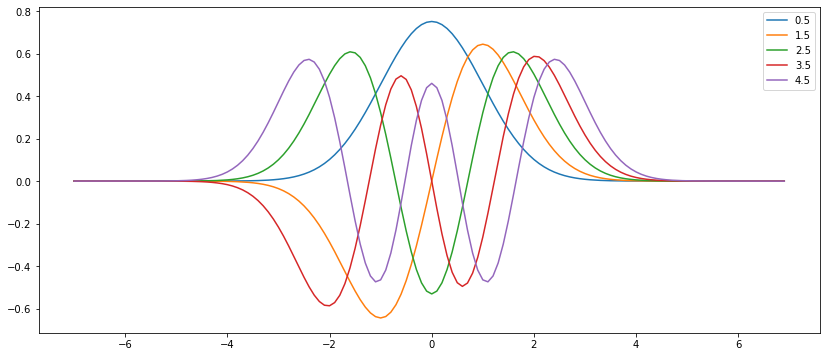

In [268]:
err=np.arange(0,M)*h**6
plt.figure(figsize=(14,6))

for En in enumerate(eigenvalues.E):
    
    y = (-1)**(En[0]) * numerov(k2(En[1]),h,0,h)
    y = y/np.sqrt(np.sum(y**2*h))

    #plot con bande di errori
    plt.plot(x,y,label=str(round(En[1],3)))
    plt.fill_between(x,y-err,y+err,alpha=0.3)

plt.legend()

## 2-nd point

In [274]:
# MASH
h=0.1
r=np.arange(0,8,h)
M=len(r)

# POTENTIAL
V = lambda r : r**2/2

#k**2
def k2_temp(E,l,V,r):
    out=(2 * (E - V(r[1:])) - (l+1)*l/r[1:]**2)
    return np.append([0],out)

k2 = lambda E , l : k2_temp(E, l, V, r)


In [275]:
# creo tabella (dataframe) degli autovalori
eigenvalues = pd.DataFrame(0, index=np.arange(len(eigen)), columns=['E','dE'])
eigenvalues.loc[:]=np.array(eigen)
eigenvalues.insert(0,'n',np.arange(n))
display(eigenvalues)

,n,E,dE
0,0,0.500000,2.910450e-13
1,1,1.499997,2.328138e-12
2,2,2.499990,9.312995e-12
3,3,3.499975,7.450573e-11
4,4,4.499949,2.980229e-10


In [282]:
eigenvalues
l=0
eigenvalues.loc[n_max*l:n_max+n_max*l-1]

,E,dE
0,0,0
1,0,0
2,0,0


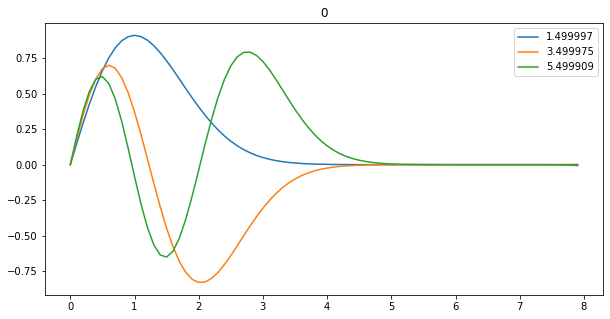

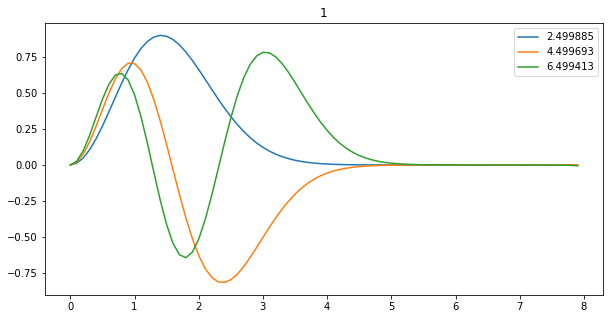

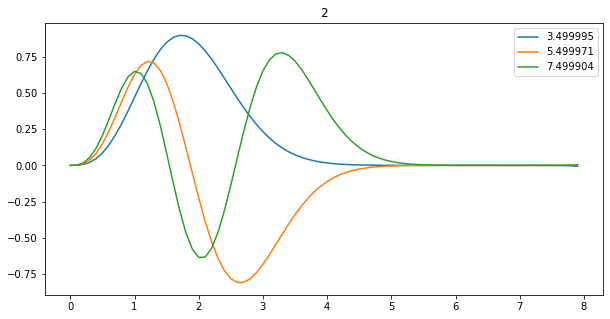

,l,n,E,dE
0,0,0,1.499997,3.641532e-14
1,0,1,3.499975,1.164402e-12
2,0,2,5.499909,3.725287e-11
3,1,0,2.499885,2.913225e-13
4,1,1,4.499693,4.656719e-12
5,1,2,6.499413,1.490115e-10
6,2,0,3.499995,1.163958e-12
7,2,1,5.499971,1.862599e-11
8,2,2,7.499904,5.960468e-10


In [291]:
l_max=3
n_max=3
eigenvalues = pd.DataFrame(0, index=np.arange(l_max*n_max), columns=['E','dE'])
n_quantum=[]
l_quantum=[]
for l in range(l_max):
    # calcolo autovalorilen(eigen)
    y = np.vectorize(lambda E : (numerov(k2(E,l),h,0,h**(l+1))))
    eigen = root_finder(y, 0, n_max, 0.01, 0.01,stop_method='n_roots')
    
    #creo tabella autovalori
    eigenvalues.loc[n_max*l:n_max+n_max*l-1]=np.array(eigen)
    
    plt.figure(figsize=(10,5))
    for En in enumerate(np.array(eigen)[:,0]):
        y = numerov(k2(En[1],l),h,0,h)
        y = y/np.sqrt(np.sum(y**2*h))
        n_quantum.append(En[0])
        l_quantum.append(l)
        #plot con bande di errori
        plt.plot(r,y,label=str(round(En[1],6)))
        err=np.arange(0,M)*h**6
        plt.fill_between(r,y-err,y+err,alpha=0.3)

    plt.title(l)
    plt.legend()
    plt.show()

eigenvalues.insert(0,'l',l_quantum)  
eigenvalues.insert(1,'n',n_quantum)    
display(eigenvalues)


# 3-rd point

In [183]:
def bessel(N):
    N=N+1
    j=list(range(N))
    j[0]=lambda x : np.sin(x)/x
    for l in range(1,N):
        if l == 1:
            j[l] = lambda x : (2*l+1)/x * j[l-1](x) - np.cos(x)/x
        else:
            j[l] = lambda x : (2*l+1)/x * j[l-1](x) - j[l-2](x)
    return j


In [189]:
j=bessel(4)
j[2](3)

RecursionError: maximum recursion depth exceeded

RecursionError: maximum recursion depth exceeded

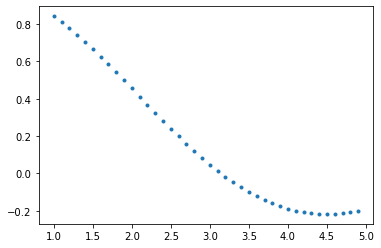

In [185]:
N=4
j=bessel(N)
x=np.arange(1,5,0.1)
for i in range(N):
    plt.plot(x,j[i](x),'.')

